In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans

# Forecast and prediction project

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.

One of the most common problems gyms and other services face is customer churn.
For a gym, it makes sense to say a customer has left if they don't come for a month. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.

In order to fight churn, Model Fitness has digitized a number of its customer profiles. 
The task is to analyze them and come up with a customer retention strategy.



We should:
- Learn to predict the probability of churn (for the upcoming month) for each customer
- Draw up typical user portraits: select the most outstanding groups and describe their main features
- Analyze the factors that impact churn the most
- Draw basic conclusions and develop recommendations on how to improve customer service:
    - Identify target groups
    - Suggest measures to cut churn
    - Describe any other patterns you see with respect to interaction with customers


# Loading and preparing the data 

**Let us load the data and have a first look at it**

In [3]:
gym_data = pd.read_csv('/datasets/gym_churn_us.csv')

In [4]:
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
gym_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Dataframe fields legend:


- 'Churn'— the fact of churn for the month in question
**Current dataset fields:**
User data for the preceding month
- 'gender'
- 'Near_Location'— whether the user lives or works in the neighborhood where the gym is located
- 'Partner'— whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
- Promo_friends— whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
- 'Phone'— whether the user provided their phone number
- 'Age'
- 'Lifetime'— the time (in months) since the customer first came to the gym
**Data from the log of visits and purchases and data on current membership status**
- 'Contract_period'— 1 month, 3 months, 6 months, or 1 year
- 'Month_to_end_contract'— the months remaining until the contract expires
- 'Group_visits'— whether the user takes part in group sessions
- 'Avg_class_frequency_total'— average frequency of visits per week over the customer's lifetime
- 'Avg_class_frequency_current_month'— average frequency of visits per week over the preceding month
- 'Avg_additional_charges_total'— the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.


## Data preprocessing 

First, column names need to be standardized

In [6]:
gym_data.columns = gym_data.columns.str.lower()

In [7]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Let's find out if there are any missing values and duplicates in the dataset

In [8]:
gym_data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [9]:
gym_data.duplicated().sum()

0

In [10]:
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Now it's time to have a look at the mean feature values in two groups: for those who left (churn) and for those who stayed.


In [11]:
gym_data_grouped = gym_data.groupby(by=['churn']).mean().reset_index().transpose().round(2)

gym_data_grouped.columns = ['stayed','left']
gym_data_grouped

,stayed,left
churn,0.00,1.00
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08


The initial look at grouped data reveals some remarkable initial insights:
1. Gender distribution in both groups is equal
2. Those customers who leave closer to the gym tend to remain a member of the Model Fitness more often
3. Discounts and benefits for employees of a partner company/promos through friends overall seem to have a positive effect on churn, since  those who stayed account for a considerably bigger propotion of customers than those who left
4. Those customers who stay are more likely to participate in group events
5. Customers who left visit the gym half as many times as those who stay

Now we can take a look at the percentage distribution by feature for those customers that stayed and those that left

In [68]:
df_churn = gym_data.query('churn == 1').drop('churn', axis=1)

print('distribution for churned customers')
for feature in df_churn.columns:
    display(df_churn[feature].value_counts(normalize=True).map("{:.1%}".format))


distribution for churned customers


1    51.1%
0    48.9%
Name: gender, dtype: object

1    76.8%
0    23.2%
Name: near_location, dtype: object

0    64.5%
1    35.5%
Name: partner, dtype: object

0    81.6%
1    18.4%
Name: promo_friends, dtype: object

1    90.3%
0     9.7%
Name: phone, dtype: object

1     88.0%
6      9.8%
12     2.2%
Name: contract_period, dtype: object

0    73.1%
1    26.9%
Name: group_visits, dtype: object

27    13.1%
28    12.8%
26    12.5%
25    12.3%
29    11.2%
24     8.2%
30     7.6%
23     5.3%
31     5.3%
32     3.4%
22     2.5%
21     1.8%
33     1.6%
20     1.0%
34     0.8%
35     0.3%
18     0.2%
19     0.1%
38     0.1%
Name: age, dtype: object

89.810082     0.1%
204.444527    0.1%
115.487561    0.1%
85.172779     0.1%
104.472327    0.1%
              ... 
189.895340    0.1%
25.030534     0.1%
425.535220    0.1%
115.359883    0.1%
116.748540    0.1%
Name: avg_additional_charges_total, Length: 1061, dtype: object

1.0     88.0%
6.0      7.2%
5.0      1.8%
12.0     1.2%
4.0      0.7%
11.0     0.4%
10.0     0.2%
2.0      0.2%
9.0      0.1%
3.0      0.1%
8.0      0.1%
7.0      0.1%
Name: month_to_end_contract, dtype: object

1    39.0%
0    38.0%
2    14.8%
3     4.7%
4     2.2%
5     0.8%
6     0.4%
8     0.1%
9     0.1%
Name: lifetime, dtype: object

0.000000    1.9%
2.223131    0.1%
2.899157    0.1%
1.250559    0.1%
1.674183    0.1%
            ... 
1.681779    0.1%
0.605093    0.1%
1.151147    0.1%
0.886548    0.1%
0.992312    0.1%
Name: avg_class_frequency_total, Length: 1042, dtype: object

0.000000    12.6%
1.844565     0.1%
1.798017     0.1%
0.789772     0.1%
2.498656     0.1%
            ...  
0.505336     0.1%
1.660564     0.1%
1.795962     0.1%
0.327703     0.1%
1.069571     0.1%
Name: avg_class_frequency_current_month, Length: 928, dtype: object

In [66]:
df_nonchurn = gym_data.query('churn == 0').drop('churn', axis=1)
print('distribution for staying customers')
for feature in df_nonchurn.columns:
    display(df_nonchurn[feature].value_counts(normalize=True).map("{:.1%}".format))

distribution for staying customers


1    51.0%
0    49.0%
Name: gender, dtype: object

1    87.3%
0    12.7%
Name: near_location, dtype: object

1    53.4%
0    46.6%
Name: partner, dtype: object

0    64.6%
1    35.4%
Name: promo_friends, dtype: object

1    90.4%
0     9.6%
Name: phone, dtype: object

1     43.3%
12    31.9%
6     24.8%
Name: contract_period, dtype: object

0    53.6%
1    46.4%
Name: group_visits, dtype: object

31    12.9%
30    12.8%
29    11.9%
32    11.2%
28    10.6%
27     8.1%
33     8.0%
26     5.7%
34     5.6%
25     3.4%
35     3.2%
24     2.1%
36     1.6%
37     1.0%
23     0.9%
38     0.3%
22     0.2%
21     0.2%
39     0.1%
20     0.1%
19     0.0%
41     0.0%
Name: age, dtype: object

89.952762     0.0%
268.097493    0.0%
79.293618     0.0%
29.953094     0.0%
196.440361    0.0%
              ... 
32.123604     0.0%
139.396467    0.0%
309.775129    0.0%
245.779728    0.0%
204.757464    0.0%
Name: avg_additional_charges_total, Length: 2939, dtype: object

1.0     43.3%
6.0     19.4%
12.0    17.4%
11.0     6.0%
5.0      3.8%
10.0     2.7%
9.0      2.4%
4.0      1.7%
8.0      1.3%
7.0      0.8%
3.0      0.7%
2.0      0.4%
Name: month_to_end_contract, dtype: object

2     15.4%
3     15.0%
1     14.6%
4     12.2%
5      9.0%
6      7.3%
7      5.7%
8      3.7%
9      3.4%
0      2.9%
10     2.6%
12     1.8%
11     1.6%
13     1.0%
15     0.8%
14     0.8%
16     0.5%
17     0.4%
19     0.2%
20     0.2%
18     0.2%
21     0.2%
22     0.1%
26     0.1%
24     0.1%
23     0.1%
27     0.0%
29     0.0%
31     0.0%
Name: lifetime, dtype: object

0.000000    2.3%
1.937791    0.0%
1.823102    0.0%
1.699092    0.0%
2.945340    0.0%
            ... 
1.707046    0.0%
0.852746    0.0%
0.747014    0.0%
3.555307    0.0%
1.317594    0.0%
Name: avg_class_frequency_total, Length: 2872, dtype: object

0.000000    1.6%
2.630594    0.0%
2.085987    0.0%
1.193288    0.0%
2.125691    0.0%
            ... 
3.282305    0.0%
2.552564    0.0%
3.103099    0.0%
2.426164    0.0%
1.454710    0.0%
Name: avg_class_frequency_current_month, Length: 2893, dtype: object

 
It is worth mentioning here, that staying customers are more likely to live near the company. 77% of churned customers and 87% of stayed customers live near Model Fitness.

35% of churned and 47% stayed customers are employees of a partner company, meaning that this feature is beneficial to our customers

18% of churned customers signed up through a "bring a friend" offer and 35% of stayed customers did the same. So recommendation of friends are beneficial to the busibess, since customers are less likely to churn.

Contract duration varies quite profoundly between churned andstayed customers. 88% of churned customers signed contract just for 1 month, with 43% of stayed customers signing for the same period. 

Hence, contract duration is an inpactful factor that brings to a conclusion, that  those customera who have contracts longer than 1 month are much less likely to churn. 

A similar picture is with time till the end of the contract. 88% of churned customers have just 1 month until the end of the contract with 43% of stayed customers having as little. There is a strong correlation between contract duration and time till the end of the contract.

Only 27% of churned customers took part at group sessions and 46% of stayed customers do. Group sessions are keeping people away from leaving.

Customers who are not planning to stay are unlikely spend money on additional services. This is backed by the data: The average check is 158 USD for stayed customers and churned customers spend on average 115 USD.

The life time span is pretty short for churned customers. Majority of them churn just after the first month or within first 2 months. Staying customers are have much longer life time period. Average Life time span for staying people is 4.7 months, and churned customers have average life time below 1 month.

Also, one should point out, that stayed customers visit gym more often. According to the data, if the customer changed his behavior and stopped visiting the gym in current month, that is a signal that he may soon churn.

**Let's plot bar histograms and feature distributions for those who left (churn) and those who stayed.**

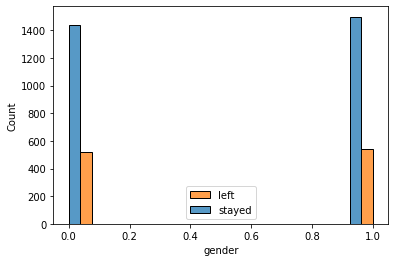

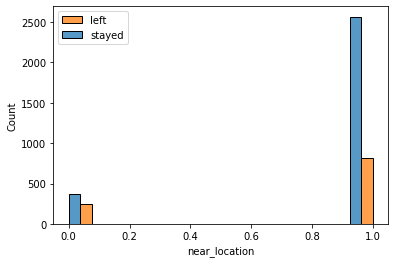

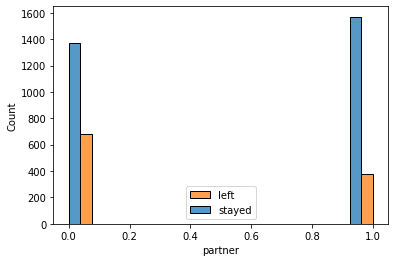

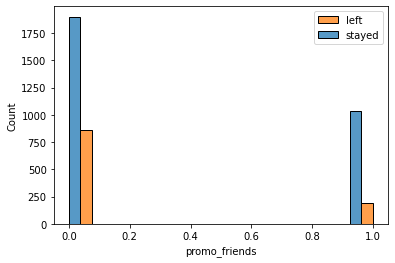

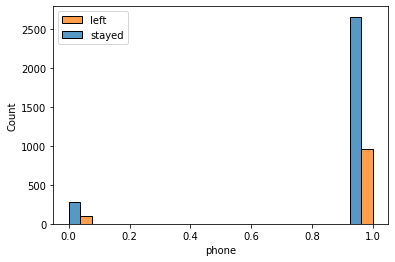

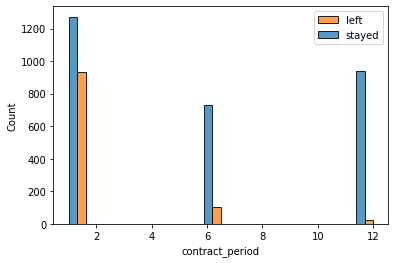

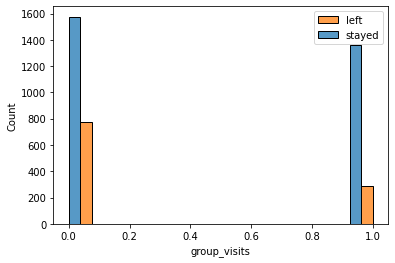

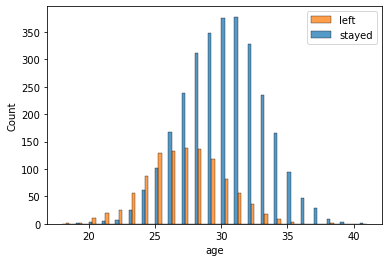

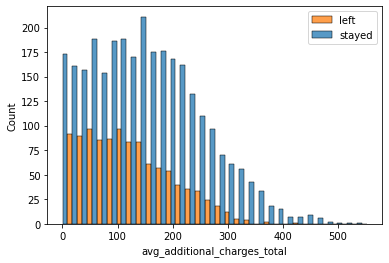

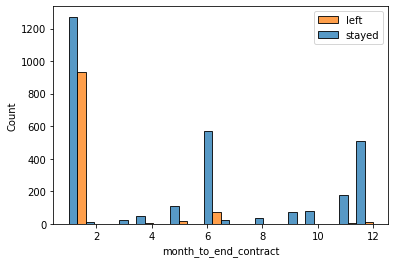

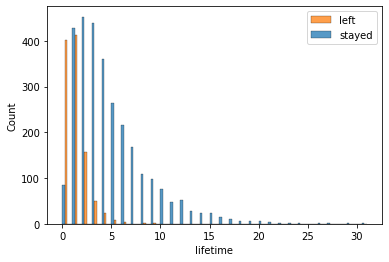

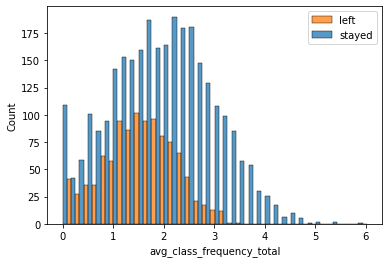

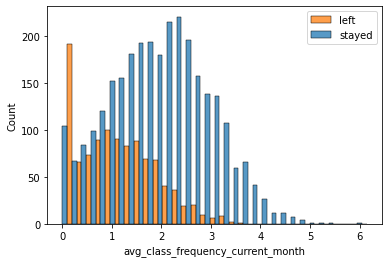

In [15]:

for feature in gym_data.drop('churn', axis=1).columns:
    sns.histplot(gym_data, x=feature, hue='churn', multiple='dodge')
    plt.legend(labels = ['left', 'stayed'])
    plt.show()


In [16]:
heatmap = gym_data.corr()
display(gym_data.corr())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


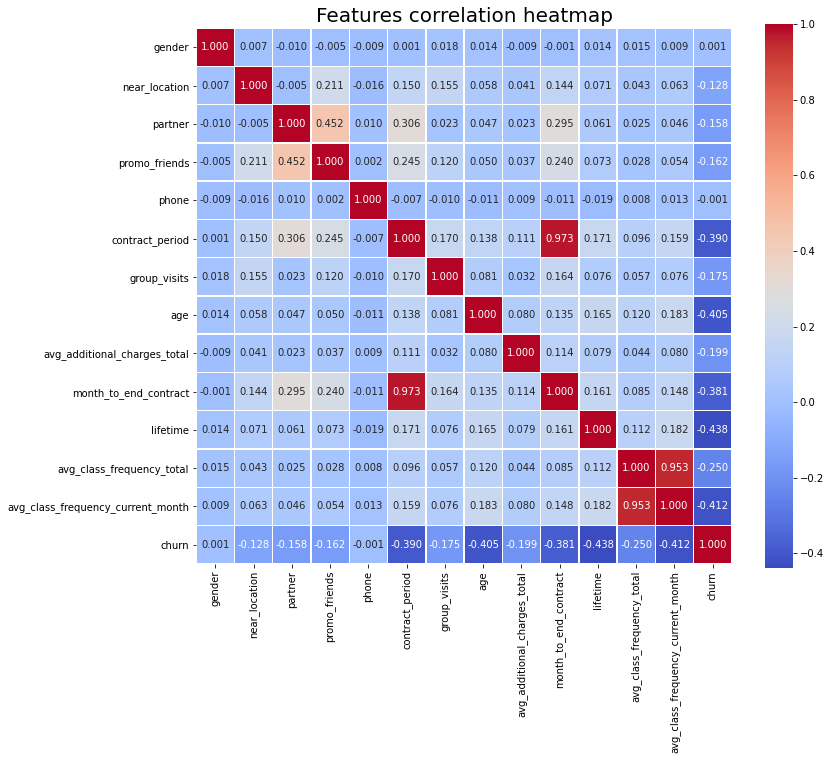

In [17]:
fig, ax = plt.subplots(figsize = (12,10))

sns.heatmap(heatmap, cmap='coolwarm', linewidth  = 0.5, square=True, annot = True, fmt = ',.3f')
plt.title("Features correlation heatmap", fontsize=20)
plt.show()

We don't see strong correlation between churn and other features but this is because we have just 2 options for most of the features. But we have very strong correlation between total weekly visits and weekly visits for last month (0.95), so we will leave just one of them - visits for the last month, it shows possible churn better as we noticed before. Also we have strong correlation between contract period and month till the end of contract (0.97). We also need to drop one of them and we will leave just contract period for the purpose of building our churn prediction model. Also during the previous analysis we saw that there is no dependence of churn on gender and phone features, we will drop those features too.

So, we will leave the following 8 features for our prediction model: near_location, partner, promo_friends, contract_period, group_visits, avg_additional_charges_total, lifetime, avg_class_frequency_current_month.

Let's look at distributions of our features where we have histograms more carefully. We will compare churn and non churn data frames, plotting histograms on one graph for churn and non churn customers.

## Build a model to predict user churn

In order to build a binary classification model for customers where the target feature is the user's leaving next month we will perform the following steps:

1. Prepare the data by removing the columns which are not our features we have determined on the previous step.
2. Create X (features) and Y (churn) samples
3. Split these data into train and test samples
4. Standardize data
5. Apply different logistic regression and random forest algorithms
6. Analyze the key metrics of the models (accuracy,precision, recall, F1)


### Removing irrelevant features

In [25]:

gym_data_clear = gym_data.drop(['avg_class_frequency_total','month_to_end_contract','gender','phone'], axis=1)
gym_data_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   near_location                      4000 non-null   int64  
 1   partner                            4000 non-null   int64  
 2   promo_friends                      4000 non-null   int64  
 3   contract_period                    4000 non-null   int64  
 4   group_visits                       4000 non-null   int64  
 5   age                                4000 non-null   int64  
 6   avg_additional_charges_total       4000 non-null   float64
 7   lifetime                           4000 non-null   int64  
 8   avg_class_frequency_current_month  4000 non-null   float64
 9   churn                              4000 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 312.6 KB


### Dividing the data into features (the X matrix) and a target variable (Y)

In [19]:
X = gym_data_clear.drop('churn', axis = 1)
Y = gym_data_clear['churn']

### Divide the data into train and validation sets using the train_test_split() function.


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

### Train the model on the train set with two methods:


- logistic regression
- random forest


In [21]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

# logistic regression

# create a StandardScaler object and apply it to the train set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)

# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

# define the model's algorithm 
lr_model = LogisticRegression(random_state = 0)
# train your model
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')


# define the model's algorithm 
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# train your model
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Metrics for random forest:')

Metrics for logistic regression:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81
	F1: 0.80
Metrics for random forest:
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.75
	F1: 0.77


### Evaluate accuracy, precision, and recall for both models using the validation data. Use them to compare the models. Which model gave better results?

Both models demonstrate high level of accuracy, which means that they accurately identified churned and staying customers. 

With regards to presicion, RandomForest model and LogisticRegression model return equal results, meaning 18% of customers were classified as staying even though they churned. 

Recall is higher in LogisticRegression model, meaning that approximately 19% of customers were classified as churn, even though they were staying.

The purpose of each model is to identify churn the following month, which is what Recall metric is about, hence it is better to identify more falsely classified churned customers rather than miss some of them. LogisticRegression modeldemonstrates better results with this regard and is better suited for the task.

## Create user clusters

### Build a matrix of distances based on the standardized feature matrix and plot a dendrogram

First let's standardize the data

In [22]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

Time to build matrix of distances

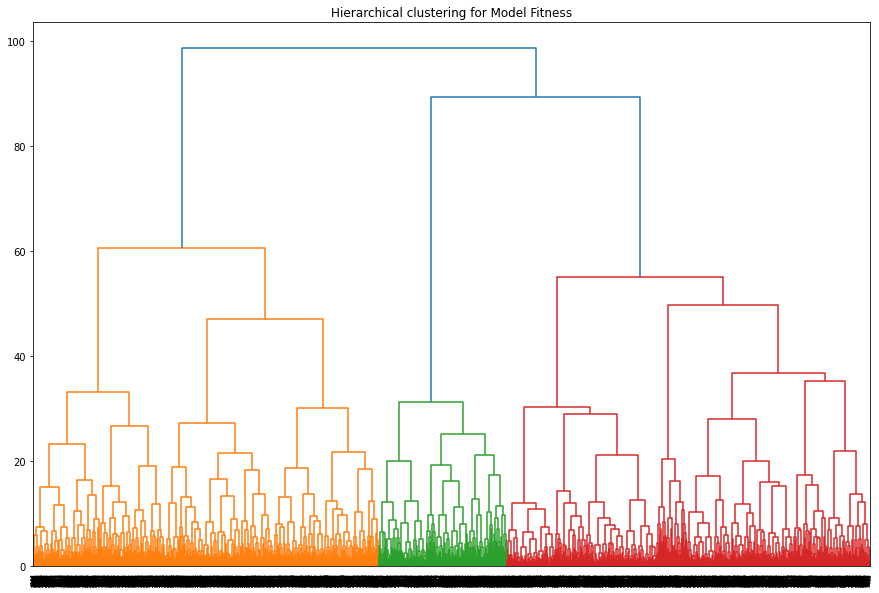

In [23]:
# Building a matrix of distances
linked = linkage(X_sc, method = 'ward')

# Plotting a dendogram
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for Model Fitness')
plt.show()

As a result we get 3 cluaters defined by color 

### Train the clustering model with the K-means algorithm and predict customer clusters.

In [35]:
# setting cluster number
km = KMeans(n_clusters = 5)

# applying the algorithm
labels = km.fit_predict(X_sc)

# storing cluster numbers in a new column of the dataframe
gym_data_clear['cluster'] = labels

df_cluster = gym_data_clear.groupby('cluster').mean().reset_index()
df_cluster

,cluster,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,0,0.000000,0.485997,0.074135,2.937397,0.225700,28.668863,136.314502,3.003295,1.592556,0.403624
1,1,0.998818,0.131206,0.086288,2.160757,0.524823,30.834515,170.254088,5.465721,2.281747,0.056738
2,2,1.000000,0.252298,0.102145,1.764045,0.256384,27.090909,114.763747,1.606742,1.100117,0.658836
3,3,0.989130,0.621377,0.000000,10.760870,0.501812,30.076087,166.100486,4.563406,2.063359,0.028986
4,4,0.995079,0.936024,1.000000,7.329724,0.531496,29.650591,154.484128,4.291339,1.924390,0.105315


### Plot distributions of features for the clusters.

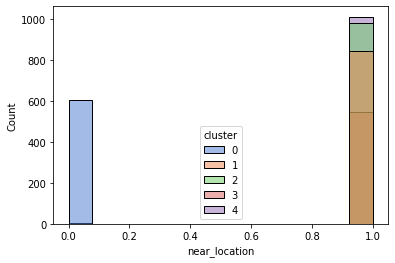

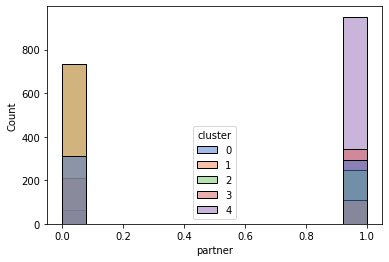

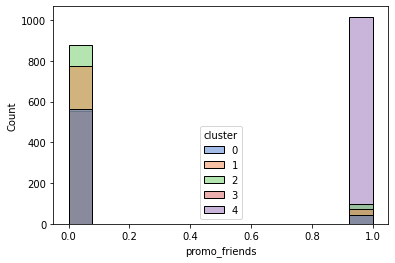

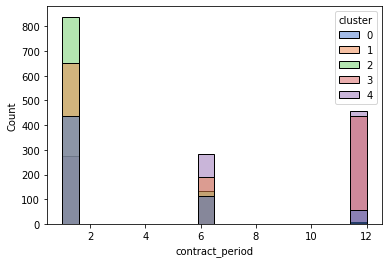

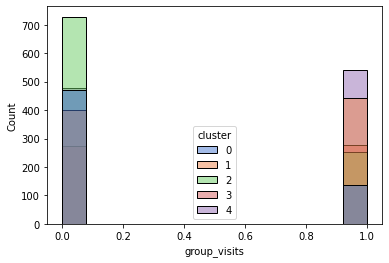

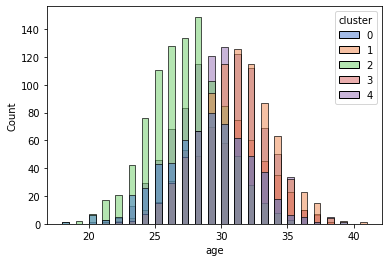

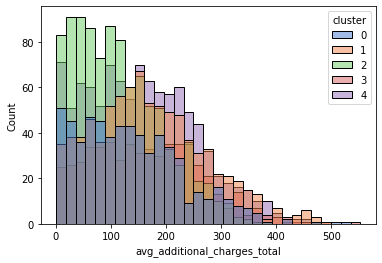

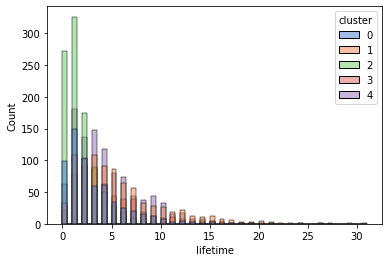

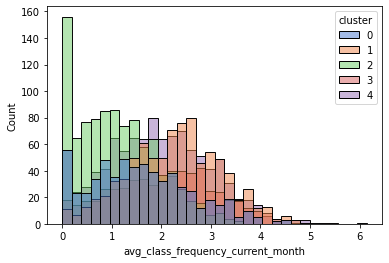

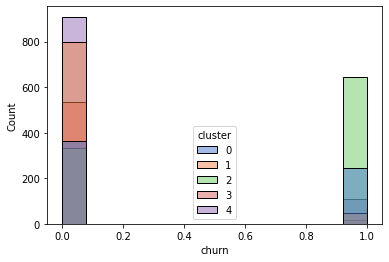

In [65]:
for feature in gym_data_clear.drop('cluster', axis=1).columns:
    sns.histplot(gym_data_clear, x=feature, hue='cluster', palette='muted')
    plt.show()

### Calculate the churn rate for each cluster


In [60]:
gym_data_clear.groupby(['cluster']).mean()['churn'].round(3).map("{:.1%}".format)

cluster
0    40.4%
1     5.7%
2    65.9%
3     2.9%
4    10.5%
Name: churn, dtype: object

We can see the lowest churn rates among clusters 1, 3 and 4 with 5.7%, 2.9%, and 10.5% churn rates respectively. 
Cluster 0 and 2 has the highest churn rate of 65.9% which also account fr the lowest contract lifetime among all clusters.

## Conclusions and basic recommendations on working with customers

In conclusion to our analysis we could state, that the most important features that influence churn of the customers are the following: the contract period they signed up for, the company's partners program and attendance frequency.

First, the signing of long-term contracts proves to be a way to reduce churn, hence the share of such contracts has to be increased. Also, new stmuli, benefits has to be invented to monivate customers choose to sighn for a long time. 

Customers who join through partnership programs are more likely to stay for longer, thus this should see major improvements in terms of marketing and partners acquisition tactics.

The more regularly customers visit the gym, the more likely they will form a habit and stay for long. In order to help them on this way, the company should bring its attention to listening what the customers have to say by conducting surveys on all aspects of their experience with the gym (training experience, convenience, equipment, cleanliness, staff, events, etc.).